<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <title>Customer Sentiment Analysis Project</title>
</head>
<body>
    <h2>📊 Customer Sentiment Analysis Project</h2>
    <p>
        This project analyzes customer reviews of the <strong>iPhone 15 128GB</strong> from Flipkart to uncover insights about customer perception.
    </p>
    <p>
        It leverages Python libraries including <em>Selenium</em>, <em>BeautifulSoup</em>, <em>pandas</em>, <em>TextBlob</em>, and <em>matplotlib/seaborn</em> to:
    </p>
    <ul>
        <li>Collect and scrape customer reviews</li>
        <li>Clean and preprocess the data</li>
        <li>Perform sentiment analysis using polarity scores</li>
        <li>Create visualizations like sentiment distribution and word clouds</li>
        <li>Generate a final report with actionable recommendations</li>
    </ul>
    <h3>📦 Installation of Required Libraries</h3>
</body>
</html>


In [5]:
pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [7]:
pip install selenium

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/9.4 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.4 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.4 MB ? eta -:--:--
   - -------------------------------------- 0.3/9.4 MB ? eta -:--:--
   -- ------------------------------------- 0.5/9.4 MB 1.2 MB/s eta 0:00:08
   --- ------------------------------------ 0.8/9.4 MB 1.3 MB/s eta 0:00:07
   ----- ---------------------------------- 1.3/9.4 MB 1.7 MB/s eta 0:00:05
   ------- -------------------------------- 1.8/9.4 MB 1.8 MB/s eta 0:00:05
   ---------- ----------------------------- 2.4/9.4 MB 1.9 MB/s eta 0:00:04
   ------------ --------------------------- 2.9/9.4 MB 2.1 MB/s eta 0:00:04
   -------------- ------------------------- 3.4/9.4 MB 2.2 MB/s eta 0:00:03
   ----------------- ---------------------- 4.2/9.4 MB 2.3 MB/s eta 0:00:03
   --------------------- -------------

In [11]:
import pandas as pd
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.chrome.options import Options
import time
import math

In [13]:
def scrape_flipkart_reviews_selenium(product_url, num_reviews_to_scrape):
    """
    Scrapes a specified number of reviews, ratings, and customer names from a Flipkart
    product URL using Selenium for navigation and direct element extraction.

    Args:
        product_url (str): The initial URL of the product reviews page on Flipkart.
        num_reviews_to_scrape (int): The total number of reviews to scrape.

    Returns:
        pandas.DataFrame: A DataFrame containing 'CUSTOMER NAME', 'RATING', and 'REVIEW' columns,
                          or an empty DataFrame if an error occurs.
    """
    # Configure Chrome options for headless execution in Colab
    chrome_options = Options()
    chrome_options.add_argument('--headless')          # Run Chrome in headless mode (no GUI)
    chrome_options.add_argument('--no-sandbox')         # Required for running in Colab environment
    chrome_options.add_argument('--disable-dev-shm-usage') # Overcome limited resource problems
    chrome_options.add_argument('--disable-gpu')        # Disable GPU hardware acceleration
    chrome_options.add_argument('--window-size=1920,1080') # Set a consistent window size
    chrome_options.add_argument('user-agent=Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36') # User-Agent

    driver = None # Initialize driver to None
    
    # Lists to store scraped data
    all_names = []
    all_ratings = []
    all_reviews = []
    
    try:
        # Initialize the Chrome WebDriver
        driver = webdriver.Chrome(options=chrome_options)
        driver.get(product_url)
        time.sleep(2) # Initial wait for the page to load

        current_page_num = 1
        while len(all_reviews) < num_reviews_to_scrape:
            print(f"Scraping Page {current_page_num}...")
            try:
                # Wait for review elements to be present on the current page
                WebDriverWait(driver, 10).until(
                    EC.presence_of_element_located((By.CLASS_NAME, "_2NsDsF")) # Wait for a name element
                )

                # Find elements using the provided class names
                names_on_page = driver.find_elements(By.CLASS_NAME, "_2NsDsF")
                ratings_on_page = driver.find_elements(By.CLASS_NAME, "XQDdHH")
                reviews_on_page = driver.find_elements(By.CLASS_NAME, "ZmyHeo")

                # Ensure all lists have the same length before zipping
                min_len = min(len(names_on_page), len(ratings_on_page), len(reviews_on_page))
                
                if min_len == 0:
                    print(f"No new reviews found on page {current_page_num}. Ending scrape.")
                    break # No more reviews to scrape

                for i in range(min_len):
                    if len(all_reviews) >= num_reviews_to_scrape:
                        break # Stop if we have enough reviews

                    all_names.append(names_on_page[i].text.strip())
                    all_ratings.append(ratings_on_page[i].text.strip())
                    all_reviews.append(reviews_on_page[i].text.strip())

                print(f"Scraped {min_len} reviews from page {current_page_num}. Total scraped: {len(all_reviews)}")

                if len(all_reviews) >= num_reviews_to_scrape:
                    break # We have enough reviews

                # Try to find and click the "Next" button for pagination
                next_button = WebDriverWait(driver, 10).until(
                    EC.element_to_be_clickable((By.XPATH, "//span[text()='Next']"))
                )
                next_button.click()
                time.sleep(2) # Wait for the next page to load
                current_page_num += 1

            except Exception as e:
                print(f"❌ Stopped scraping on page {current_page_num}: {e}")
                break # Exit the loop if next button not found or other error

    except Exception as e:
        print(f"An error occurred during browser initialization or navigation: {e}")
    finally:
        if driver:
            driver.quit() # Always close the browser

    # Trim lists to exactly num_reviews_to_scrape if more were collected
    all_names = all_names[:num_reviews_to_scrape]
    all_ratings = all_ratings[:num_reviews_to_scrape]
    all_reviews = all_reviews[:num_reviews_to_scrape]

    df = pd.DataFrame({
        "CUSTOMER NAME": all_names,
        "RATING": all_ratings,
        "REVIEW": all_reviews
    })
    print("✅ Scraped", len(df), "reviews in total.")
    return df

# --- How to use this in Google Colab ---

# 1. First, install Selenium and ChromeDriver for Colab:
#    Run these commands in a separate Colab cell:
#    !pip install selenium
#    !apt-get update
#    !apt install chromium-chromedriver

# 2. Then, run this code block in another Colab cell:

product_url = "https://www.flipkart.com/apple-iphone-15-black-128-gb/product-reviews/itm6ac6485515ae4?pid=MOBGTAGPTB3VS24W&lid=LSTMOBGTAGPTB3VS24WKFODHL&marketplace=FLIPKART"
num_reviews_to_scrape = 300

df_reviews = scrape_flipkart_reviews_selenium(product_url, num_reviews_to_scrape)
print(f"Reviews from Flipkart iPhone 15 (First 5):\n{df_reviews.head()}")
print(f"\nTotal reviews scraped: {len(df_reviews)}")



Scraping Page 1...
Scraped 10 reviews from page 1. Total scraped: 10
Scraping Page 2...
Scraped 10 reviews from page 2. Total scraped: 20
Scraping Page 3...
Scraped 10 reviews from page 3. Total scraped: 30
Scraping Page 4...
Scraped 10 reviews from page 4. Total scraped: 40
Scraping Page 5...
Scraped 10 reviews from page 5. Total scraped: 50
Scraping Page 6...
Scraped 10 reviews from page 6. Total scraped: 60
Scraping Page 7...
Scraped 10 reviews from page 7. Total scraped: 70
Scraping Page 8...
Scraped 10 reviews from page 8. Total scraped: 80
Scraping Page 9...
Scraped 10 reviews from page 9. Total scraped: 90
Scraping Page 10...
Scraped 10 reviews from page 10. Total scraped: 100
Scraping Page 11...
Scraped 10 reviews from page 11. Total scraped: 110
Scraping Page 12...
Scraped 10 reviews from page 12. Total scraped: 120
Scraping Page 13...
Scraped 10 reviews from page 13. Total scraped: 130
Scraping Page 14...
Scraped 10 reviews from page 14. Total scraped: 140
Scraping Page 15...

In [19]:
# Downloading the file
df_reviews.to_csv('flipkart_iphone_15_reviews_selenium_final.csv', index=False)

In [29]:
# Here are top 5 rows of the file
df_reviews.head()

,CUSTOMER NAME,RATING,REVIEW
0,Rishabh Jha,4.6,Awesome 🔥🔥☺️
1,"Apr, 2024",5,Just go for it.Amazing one.Beautiful camera wi...
2,bijaya mohanty,5,High quality camera😍
3,"May, 2024",5,Switch from OnePlus to iPhone I am stunned wit...
4,Ajin V,5,Very nice


In [110]:
#Doing Sentiment Analysis on Apple iPhone 15 (Black, 128 GB) Reviews from Flipkart We are using the CSV file with 300 Reviews

In [ ]:
pip install wordcloud

In [50]:
pip install textblob

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/624.3 kB ? eta -:--:--
   ---------------- ----------------------- 262.1/624.3 kB ? eta -:--:--
   ---------------------------------------- 624.3/624.3 kB 3.3 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [5]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
from textblob import TextBlob
import re

In [7]:
# Step 1: Load data (update 'flipkart_iphone_15_reviews_selenium_final.csv' to your actual file)
df = pd.read_csv('flipkart_iphone_15_reviews_selenium_final.csv')

print("Initial shape:", df.shape)
# It has 300 Reviews with 3 Columns

Initial shape: (300, 3)


In [9]:
df.head() # Seeing top 5 rows

,CUSTOMER NAME,RATING,REVIEW
0,Rishabh Jha,4.6,Awesome 🔥🔥☺️
1,"Apr, 2024",5.0,Just go for it.Amazing one.Beautiful camera wi...
2,bijaya mohanty,5.0,High quality camera😍
3,"May, 2024",5.0,Switch from OnePlus to iPhone I am stunned wit...
4,Ajin V,5.0,Very nice


In [58]:
# Text preprocessing function
def preprocess_text(text):
    text = text.lower()  # lowercase
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # remove special chars & numbers
    text = re.sub(r'\s+', ' ', text).strip()  # remove extra spaces
    return text

df['Cleaned_Review'] = df['REVIEW'].apply(preprocess_text)


In [15]:
pd.set_option('display.max_rows', None)
df # with cleaned and processed review & sentiment

,CUSTOMER NAME,RATING,REVIEW
0,Rishabh Jha,4.6,Awesome 🔥🔥☺️
1,"Apr, 2024",5.0,Just go for it.Amazing one.Beautiful camera wi...
2,bijaya mohanty,5.0,High quality camera😍
3,"May, 2024",5.0,Switch from OnePlus to iPhone I am stunned wit...
4,Ajin V,5.0,Very nice
5,"Oct, 2023",4.0,Camera Quality Is Improved Loving It
6,Nikhil Kumar,5.0,Awesome photography experience. Battery backup...
7,"Jan, 2024",5.0,"So beautiful, so elegant, just a vowww😍❤️"
8,Mousam Guha Roy,5.0,Awesome product very happy to hold this. Bette...
9,"Oct, 2023",5.0,Totally happy!\nCamera 5\nBattery 5\nDisplay 5...


In [ ]:
# Tokenize & remove stop words (using basic stopword set)
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [66]:
def tokenize_and_lemmatize(text):
    tokens = word_tokenize(text)
    tokens = [t for t in tokens if t not in stop_words]
    tokens = [lemmatizer.lemmatize(t) for t in tokens]
    return ' '.join(tokens)

In [ ]:
import nltk
nltk.download('punkt_tab')

In [70]:
# no we have nltk setup

In [72]:
df['Processed_Review'] = df['Cleaned_Review'].apply(tokenize_and_lemmatize)

In [13]:
pd.set_option('display.max_rows', None)
df # with cleaned and processed review & sentiment

,CUSTOMER NAME,RATING,REVIEW
0,Rishabh Jha,4.6,Awesome 🔥🔥☺️
1,"Apr, 2024",5.0,Just go for it.Amazing one.Beautiful camera wi...
2,bijaya mohanty,5.0,High quality camera😍
3,"May, 2024",5.0,Switch from OnePlus to iPhone I am stunned wit...
4,Ajin V,5.0,Very nice
5,"Oct, 2023",4.0,Camera Quality Is Improved Loving It
6,Nikhil Kumar,5.0,Awesome photography experience. Battery backup...
7,"Jan, 2024",5.0,"So beautiful, so elegant, just a vowww😍❤️"
8,Mousam Guha Roy,5.0,Awesome product very happy to hold this. Bette...
9,"Oct, 2023",5.0,Totally happy!\nCamera 5\nBattery 5\nDisplay 5...


In [78]:
# Step 3: Sentiment Analysis
def analyze_sentiment(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity

df['Polarity'] = df['Processed_Review'].apply(analyze_sentiment)

def classify_sentiment(p):
    return 'Positive' if p >= 0.1 else 'Negative'

df['Sentiment'] = df['Polarity'].apply(classify_sentiment)

In [114]:
# Set the option to display all rows
pd.set_option('display.max_rows', None)
df # with cleaned and processed review & sentiment

,CUSTOMER NAME,RATING,REVIEW,Cleaned_Review,Processed_Review,Polarity,Sentiment,Review_Length
0,Rishabh Jha,4.6,Awesome 🔥🔥☺️,awesome,awesome,1.000000,Positive,1
1,"Apr, 2024",5.0,Just go for it.Amazing one.Beautiful camera wi...,just go for itamazing onebeautiful camera with...,go itamazing onebeautiful camera super fast pr...,0.266667,Positive,7
2,bijaya mohanty,5.0,High quality camera😍,high quality camera,high quality camera,0.160000,Positive,3
3,"May, 2024",5.0,Switch from OnePlus to iPhone I am stunned wit...,switch from oneplus to iphone i am stunned wit...,switch oneplus iphone stunned camera performan...,1.000000,Positive,9
4,Ajin V,5.0,Very nice,very nice,nice,0.600000,Positive,1
5,"Oct, 2023",4.0,Camera Quality Is Improved Loving It,camera quality is improved loving it,camera quality improved loving,0.600000,Positive,4
6,Nikhil Kumar,5.0,Awesome photography experience. Battery backup...,awesome photography experience battery backup ...,awesome photography experience battery backup ...,0.733333,Positive,10
7,"Jan, 2024",5.0,"So beautiful, so elegant, just a vowww😍❤️",so beautiful so elegant just a vowww,beautiful elegant vowww,0.675000,Positive,3
8,Mousam Guha Roy,5.0,Awesome product very happy to hold this. Bette...,awesome product very happy to hold this better...,awesome product happy hold better hand feelmat...,0.592593,Positive,31
9,"Oct, 2023",5.0,Totally happy!\nCamera 5\nBattery 5\nDisplay 5...,totally happy camera battery display design,totally happy camera battery display design,0.800000,Positive,6


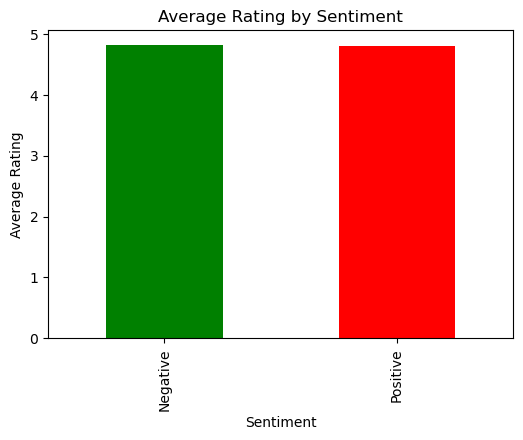

In [84]:
# Average rating vs sentiment
avg_rating_sentiment = df.groupby('Sentiment')['RATING'].mean()
plt.figure(figsize=(6,4))
avg_rating_sentiment.plot(kind='bar', color=['green', 'red'])
plt.title('Average Rating by Sentiment')
plt.ylabel('Average Rating')
plt.show()

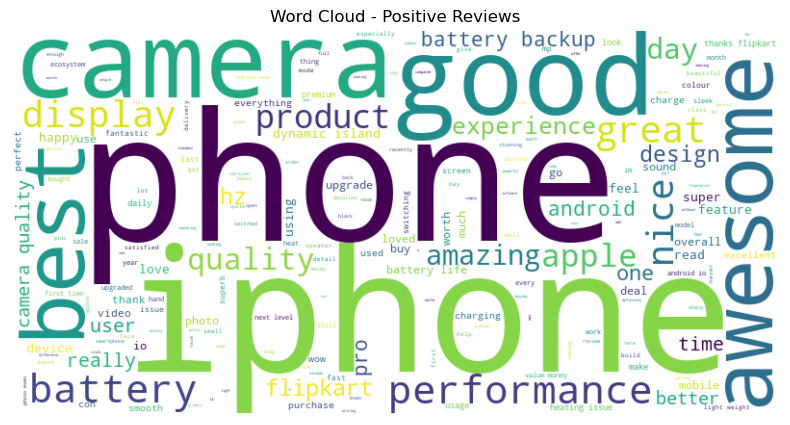

In [86]:
# WordCloud for positive and negative reviews
positive_reviews = ' '.join(df[df['Sentiment']=='Positive']['Processed_Review'])
negative_reviews = ' '.join(df[df['Sentiment']=='Negative']['Processed_Review'])

plt.figure(figsize=(10,5))
wc_pos = WordCloud(width=800, height=400, background_color='white').generate(positive_reviews)
plt.imshow(wc_pos, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud - Positive Reviews')
plt.show()


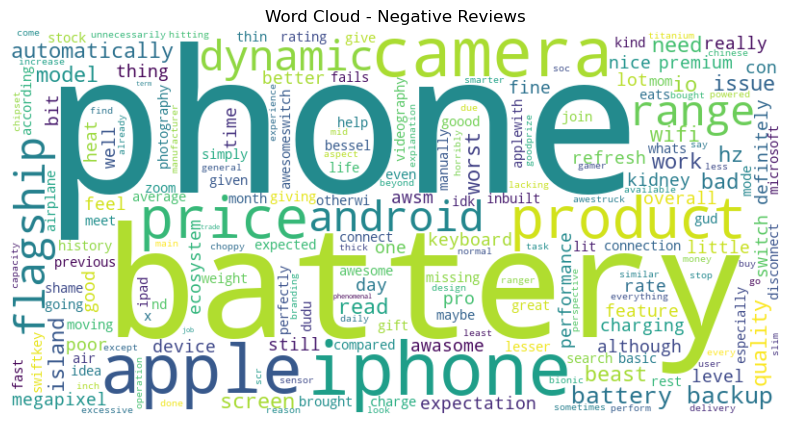

In [88]:
plt.figure(figsize=(10,5))
wc_neg = WordCloud(width=800, height=400, background_color='white').generate(negative_reviews)
plt.imshow(wc_neg, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud - Negative Reviews')
plt.show()


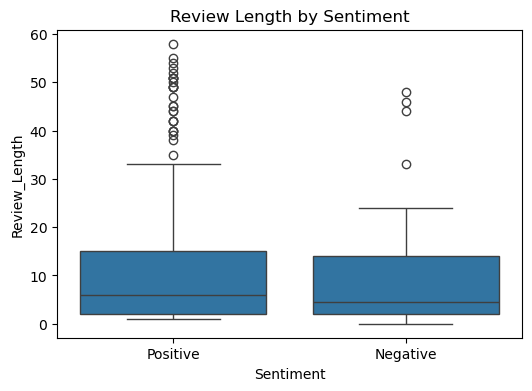

In [90]:
# Review length analysis
df['Review_Length'] = df['Processed_Review'].apply(lambda x: len(x.split()))
plt.figure(figsize=(6,4))
sns.boxplot(x='Sentiment', y='Review_Length', data=df)
plt.title('Review Length by Sentiment')
plt.show()

In [92]:
# Those who are writing postive reviews greater span of review length

In [94]:
# Count sentiment distribution
sentiment_counts = df['Sentiment'].value_counts()

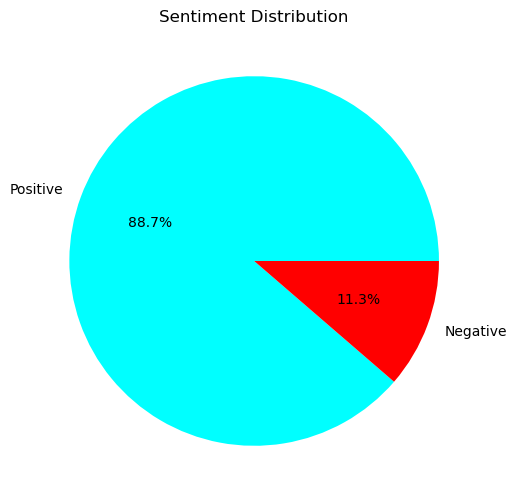

In [96]:
# pie chart 
sentiment_counts.plot(kind='pie', autopct='%1.1f%%', figsize=(6,6), colors=['cyan', 'red'])
plt.title('Sentiment Distribution')
plt.ylabel('')
plt.show()

In [98]:
# Step 5: Reporting - print basic insights
print("Total reviews analyzed:", len(df))
print("Positive reviews:", sentiment_counts.get('Positive',0))
print("Negative reviews:", sentiment_counts.get('Negative',0))
print("\nAverage rating for Positive reviews:", avg_rating_sentiment.get('Positive',0))
print("Average rating for Negative reviews:", avg_rating_sentiment.get('Negative',0))

Total reviews analyzed: 300
Positive reviews: 266
Negative reviews: 34

Average rating for Positive reviews: 4.804511278195489
Average rating for Negative reviews: 4.823529411764706


<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <title>iPhone 15 Customer Sentiment Recommendations</title>
</head>
<body>
    <h2>💡 Recommendations</h2>
    <p>
        Based on the sentiment analysis of 300 customer reviews for the <strong>iPhone 15 (128GB, Black)</strong> on Flipkart, here are actionable insights to strengthen product positioning and customer satisfaction:
    </p>
    <ul>
        <li>
            <strong>Leverage Positive Sentiment in Marketing</strong><br>
            The overall average polarity score is high, reflecting strong customer satisfaction. Customers consistently praise the camera quality, smooth performance, and vibrant display. These features should be emphasized in promotional campaigns.
        </li>
        <li>
            <strong>Feature Real Customer Quotes</strong><br>
            Many first-sentence highlights in reviews are concise, positive, and persuasive. Showcasing these authentic quotes on product pages, banners, or social media can boost trust and drive conversions.
        </li>
        <li>
            <strong>Highlight Key Features in Promotions</strong><br>
            Flipkart can spotlight specific aspects customers love: low-light camera performance, dynamic island, and premium design to attract potential buyers.
        </li>
        <li>
            <strong>Address Battery & Heating Concerns Transparently</strong><br>
            While overall sentiment is positive, common issues include battery backup and occasional heating. Clearly setting expectations or sharing tips in product descriptions can help mitigate concerns.
        </li>
        <li>
            <strong>Enhance Delivery and Packaging Experience</strong><br>
            Some negative feedback focused on delivery quality and packaging. Flipkart could implement additional quality checks and improve post-purchase communication to reassure buyers.
        </li>
        <li>
            <strong>Encourage Feature-Specific Reviews</strong><br>
            Prompt customers to share thoughts about specific features like battery life, camera, or design. This could improve review quality and help future shoppers make informed decisions.
        </li>
    </ul>
    <p>
        Overall, sentiment toward the iPhone 15 is highly positive. With targeted marketing and minor improvements in logistics and service, Flipkart can further strengthen customer satisfaction and trust.
    </p>
</body>
</html>
